## PCA aplicado a imágenes satelitales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Levantamos y visualizamos la imagen

In [2]:
def normalize_percentile(band, pmin=2, pmax=98):
    # Normaliza una banda usando percentiles para mejorar el contraste
    lower = np.percentile(band, pmin)
    upper = np.percentile(band, pmax)
    return np.clip((band - lower) / (upper - lower), 0, 1)

In [3]:
with rasterio.open('../img/landsat_sample.tif') as src:
    img = src.read()  # bandas, alto, ancho
    profile = src.profile  # preserva la metadata
img.shape

(19, 347, 347)

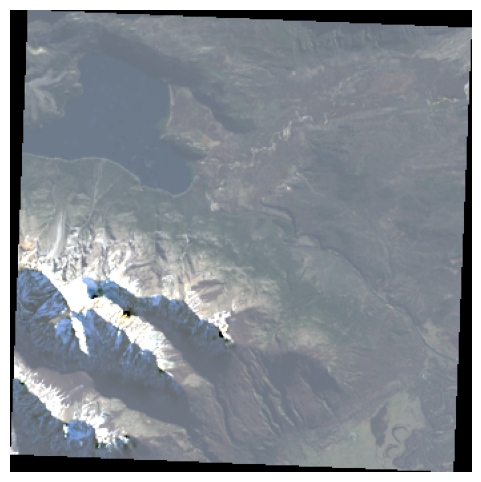

In [4]:
# Landsat 8: [4, 3, 2] → rojo, verde, azul

r = normalize_percentile(img[3])
g = normalize_percentile(img[2])
b = normalize_percentile(img[1])

# Composición de la imagen RGB normalizada
rgb_stretched = np.stack([r, g, b], axis=-1)

plt.figure(figsize=(6, 6))
plt.imshow(rgb_stretched)
plt.axis('off')
plt.show()


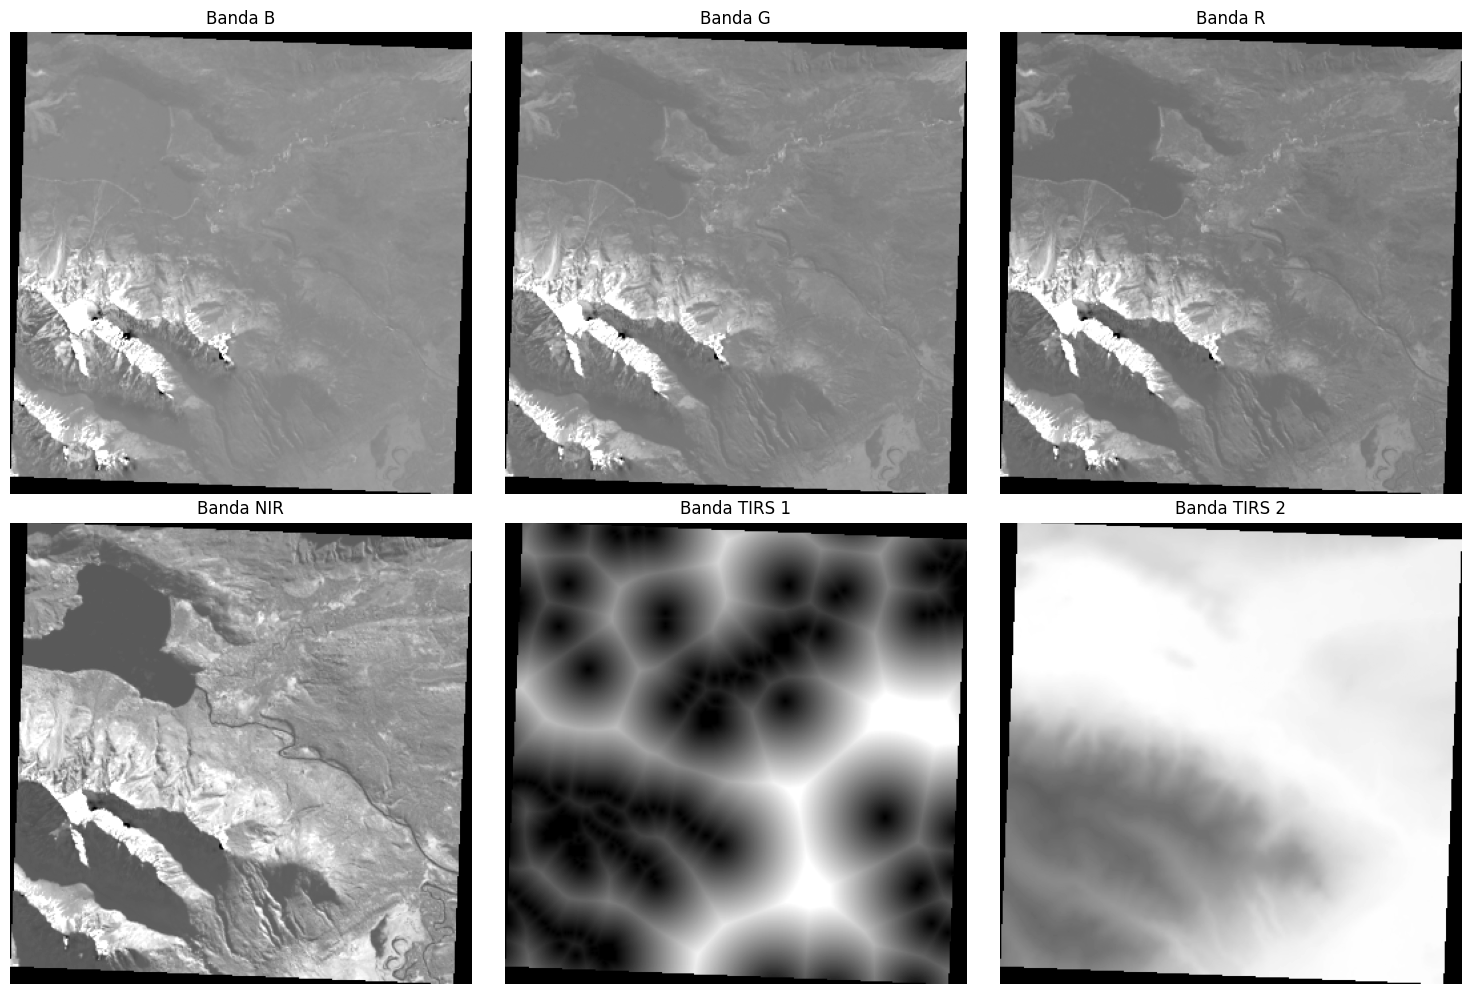

In [5]:
# Muestra de 6 bandas (selección)
    
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

bandas = [1, 2, 3, 4, 10, 11]  #  6 bandas
nombres = ['B', 'G', 'R', 'NIR','TIRS 1', 'TIRS 2']
for i, banda in enumerate(bandas):
    ax = axes[i // 3, i % 3]
    img_n = normalize_percentile(img[banda])
    ax.imshow(img_n, cmap='gray')
    ax.set_title(f'Banda {nombres[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


### Aplicamos PCA

In [6]:
bands, height, width = img.shape
img_2d = img.reshape(bands, -1).T  # shape: (pixels, bands)

X_scaled = StandardScaler().fit_transform(img_2d)

pca = PCA(n_components=bands)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(120409, 19)

### Graficamos los tres primeros componentes

#### IMPORTANTE!
PCA no conserva las bandas individuales. Por lo tanto, se pierde interpretabilidad.

In [7]:
pca_image = X_pca[:, :3].T.reshape(3, height, width)
pca_image.shape

(3, 347, 347)

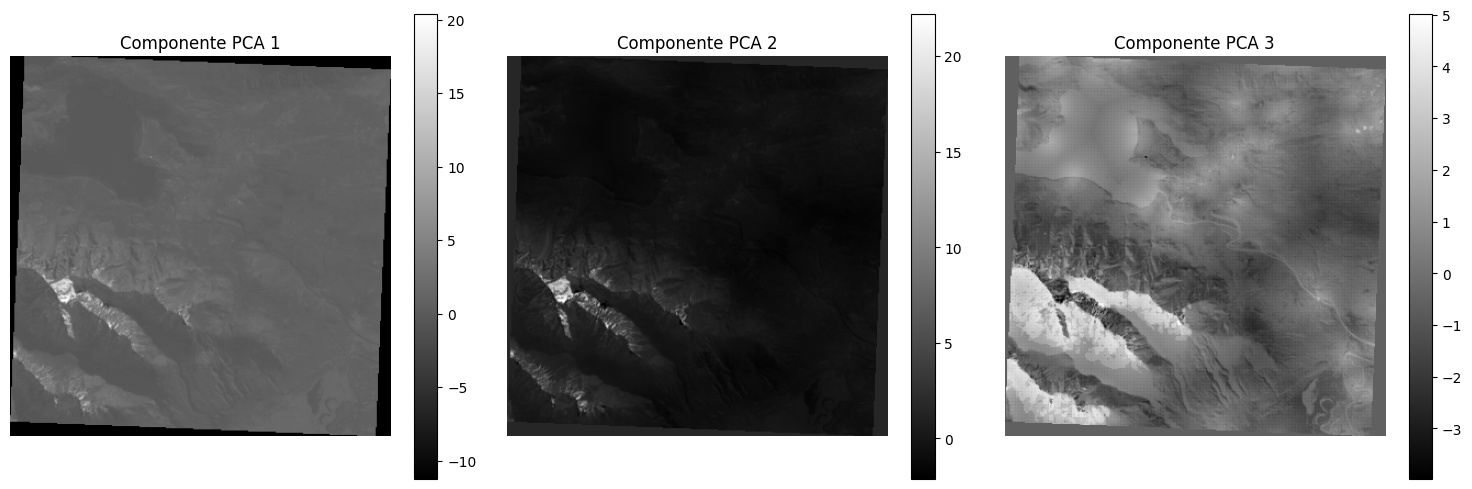

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    img = axes[i].imshow(pca_image[i], cmap='gray')
    axes[i].set_title(f'Componente PCA {i+1}')
    axes[i].axis('off')
    fig.colorbar(img, ax=axes[i])
    
plt.tight_layout()
plt.show()

### Explicamos la varianza

In [9]:
# varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_

# varianza acumulada
cumulative_var = np.cumsum(explained_var)

n_components = len(explained_var)
componentes = np.arange(1, n_components + 1)

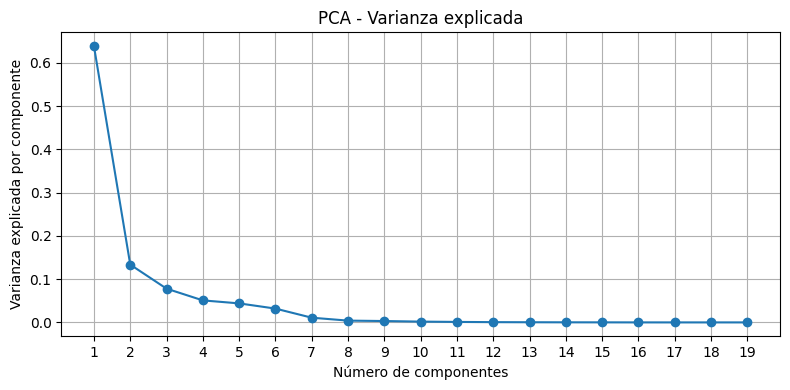

Varianza explicada por cada componente:
[6.38902148e-01 1.33619827e-01 7.80570741e-02 5.09262287e-02
 4.39929997e-02 3.19528818e-02 1.09018950e-02 4.12889631e-03
 3.18531177e-03 1.84146581e-03 1.13397548e-03 6.15047916e-04
 3.75816157e-04 2.14208750e-04 1.24294598e-04 2.59122040e-05
 1.87835240e-06 1.38492808e-07 0.00000000e+00]


In [10]:
# varianza explicada por cada componente
plt.figure(figsize=(8, 4))
plt.plot(componentes, explained_var, marker='o')
plt.xticks(componentes)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada por componente')
plt.title('PCA - Varianza explicada')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Varianza explicada por cada componente:\n{explained_var}')

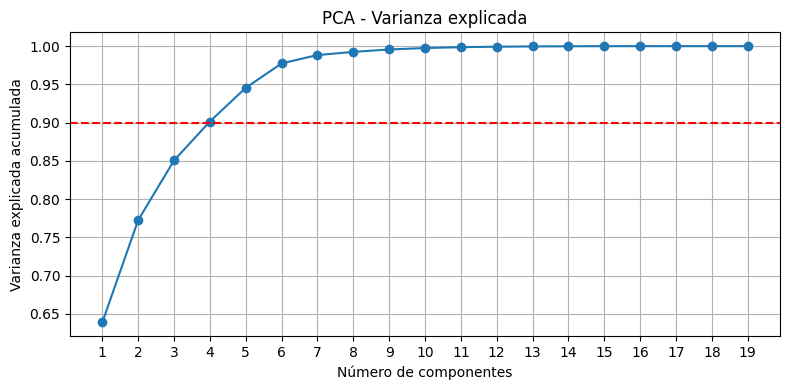

Varianza explicada acumulada:
[0.63890215 0.77252197 0.85057905 0.90150528 0.94549828 0.97745116
 0.98835305 0.99248195 0.99566726 0.99750873 0.9986427  0.99925775
 0.99963357 0.99984778 0.99997207 0.99999798 0.99999986 1.
 1.        ]


In [11]:
plt.figure(figsize=(8, 4))
plt.plot(componentes, cumulative_var, marker='o')
plt.xticks(componentes)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('PCA - Varianza explicada')
plt.grid(True)
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.tight_layout()
plt.show()

print(f'Varianza explicada acumulada:\n{cumulative_var}')